In [1]:
#Bollinger Bands

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Price,Adj Close,Close,High,Low,Open,Volume,BB_SMA,BB_STD,Upper_Band,Lower_Band,Strategy,Asset_Returns,Strategy_Returns
Date,,,,,,,,,,,,,
2021-08-04,414.830292,438.980011,441.119995,438.730011,439.779999,46732200,436.157997,4.118717,444.395431,427.920564,0.0,NaN,NaN
2021-08-05,417.457306,441.760010,441.850006,439.880005,440.220001,38969700,436.699997,4.106372,444.912741,428.487253,0.0,0.006333,0.000000
2021-08-06,418.147186,442.489990,442.940002,441.799988,442.100006,46930000,437.048497,4.292503,445.633503,428.463491,0.0,0.007996,0.000000
2021-08-09,417.806976,442.130005,442.799988,441.309998,442.459991,41222600,437.300998,4.440434,446.181867,428.420129,0.0,0.007176,0.000000
2021-08-10,418.326691,442.679993,443.440002,441.880005,442.609985,43339300,437.655498,4.577544,446.810587,428.500409,0.0,0.008429,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-24,606.780029,606.780029,607.849976,603.409973,604.330017,67735300,596.948508,5.238038,607.424584,586.472432,0.0,0.382250,-0.050593
2025-06-25,607.119995,607.119995,608.609985,605.539978,607.909973,62114800,597.747006,5.517382,608.781770,586.712243,0.0,0.383024,-0.050593
2025-06-26,611.869995,611.869995,612.309998,608.369995,608.989990,78548400,598.954007,5.841636,610.637279,587.270735,0.0,0.393845,-0.050593


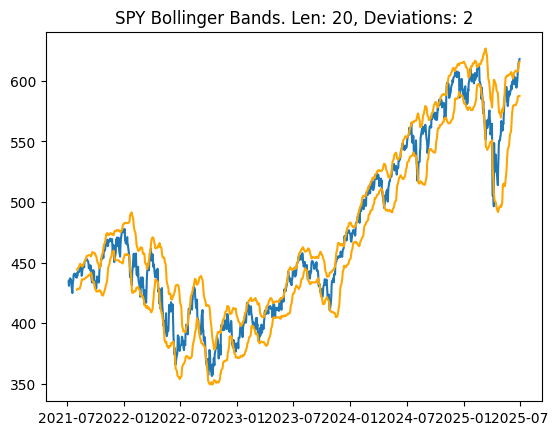

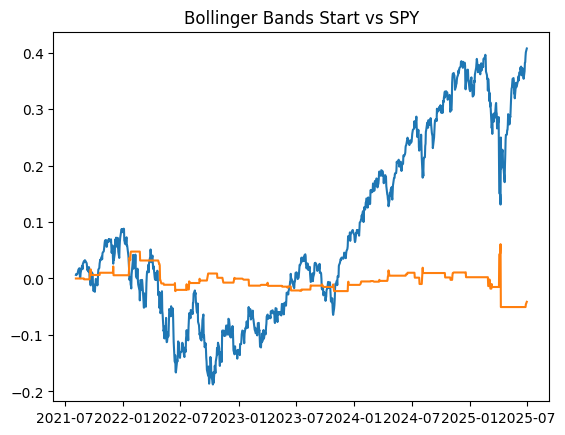

In [ ]:
#volatility-based technical indicator, They create a dynamic channel around price, adjusting to volatility.
#based on standard deviation of close prices
#say looking for signals that exceed extremely strenuous values, like share price +- 3 SD


TICKER = 'SPY'
BB_LENGTH = 20
DEVS = 2
LOOKBACK = 1000

def get_data(ticker=TICKER, lookback=LOOKBACK):
    df = yf.download(
        ticker,
        start='1993-01-29',
        end='2025-07-01',
        interval='1d',
        auto_adjust=False,
        progress=False,
        threads=False
    )
    df.columns = df.columns.get_level_values(0)
    return df.dropna().iloc[-lookback:, :]



#Upper Band = “expensive/extreme high” (relative to recent price & volatility)
#Lower Band = “cheap/extreme low” (relative to recent price & volatility)
#Middle Band = mean (20-day SMA by default)

#If the price is outside the bands, it suggests a rare/extreme move 

def add_bollinger_band(df, devs=DEVS, bb_len=BB_LENGTH):
    #could also use ema(expo moving avg)
    df['BB_SMA'] = df['Close'].rolling(bb_len).mean()

    #get the sd for close prices for period
    df['BB_STD'] = df['Close'].rolling(bb_len).std()

    df['Upper_Band'] = df['BB_SMA'] + (devs* df['BB_STD'])
    df['Lower_Band'] = df['BB_SMA'] - (devs* df['BB_STD'])


    plt.plot(df['Close'])
    plt.plot(df['Upper_Band'], color = 'orange')
    plt.plot(df['Lower_Band'], color = 'orange')

    plt.title(f'{TICKER} Bollinger Bands. Len: {BB_LENGTH}, Deviations: {DEVS}')



    return df.dropna()


def add_strategy(df):
    df['Strategy'] = 0

    #when close>upper go short, else
    #Go Long (buy):
    #When the price closes below the lower band → likely oversold → expect it to bounce back toward the mean.
    df['Strategy'] = np.where(df['Close']> df['Upper_Band'],-1,
                              np.where(df['Close']<df['Lower_Band'],1,0))
    
    df['Strategy'] = df['Strategy'].shift(1)

    return df.dropna()


def test_strategy(df):
    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change()*df['Strategy']).cumprod() - 1
    

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.title(f'Bollinger Bands Start vs {TICKER}')

    return df
    

def main():
    df = get_data()
    df = add_bollinger_band(df)
    df = add_strategy(df)
    df = test_strategy(df)

    return df

df = main()
df

